In [55]:
import os
import cv2
import numpy as np
from imutils import face_utils
import dlib

# Image Preprocessing 

In [ ]:
input_folder = "archive/train"
processed_folder = "D:\\2. College project\\drowsiness detection while driving-sem5\\driver_drowsiness_system_CNN\\processed_images"
face_cascade = cv2.CascadeClassifier('data/haarcascade_frontalface_default.xml') 
predictor = dlib.shape_predictor('data/shape_predictor_68_face_landmarks.dat')

In [ ]:
def preprocess_yawn_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to read image: {image_path}")
        return None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    detector = dlib.get_frontal_face_detector()
    faces = detector(gray, 1)
    if len(faces) == 0:
        print(f"No face detected in image: {image_path}")
        return None
    
    for face in faces:
        rect = dlib.rectangle(face.left(), face.top(), face.right(), face.bottom())
        landmarks = predictor(gray, rect)
        landmarks = face_utils.shape_to_np(landmarks)

        mouth_points = landmarks[48:68]
        
        (x_min, y_min) = mouth_points.min(axis=0)
        (x_max, y_max) = mouth_points.max(axis=0)
        
        # Crop area mulut
        mouth = gray[y_min:y_max, x_min:x_max]
        
        mouth_resized = cv2.resize(mouth, (64, 64))
        mouth_normalized = mouth_resized / 255.0
        mouth_final = np.expand_dims(mouth_normalized, axis=-1)
        
        return mouth_final

In [ ]:
def preprocess_eye_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Failed to read image: {image_path}")
        return None

    eye_resized = cv2.resize(img, (64, 64))
    eye_normalized = eye_resized / 255.0
    eye_final = np.expand_dims(eye_normalized, axis=-1)
    
    return eye_final

In [ ]:
def process_and_save_images(input_folder, processed_folder):
    if not os.path.exists(processed_folder):
        os.makedirs(processed_folder)

    for category in os.listdir(input_folder):
        category_path = os.path.join(input_folder, category)
        output_category_folder = os.path.join(processed_folder, category)
        if not os.path.exists(output_category_folder):
            os.makedirs(output_category_folder)
        
        for filename in os.listdir(category_path):
            image_path = os.path.join(category_path, filename)

            if category in ['yawn', 'no_yawn']:
                processed_image = preprocess_yawn_image(image_path)
            elif category in ['Closed', 'Open']:
                processed_image = preprocess_eye_image(image_path)
            else:
                print(f"Skipped unknown category: {category}")
                continue
            
            if processed_image is not None:
                processed_image = (processed_image * 255).astype(np.uint8)
                output_path = os.path.join(output_category_folder, filename)
                cv2.imwrite(output_path, processed_image)
                print(f"Processed and saved: {output_path}")

process_and_save_images(input_folder, processed_folder)

Processed and saved: D:\2. College project\drowsiness detection while driving-sem5\driver_drowsiness_system_CNN\processed_images\Closed\_0.jpg
Processed and saved: D:\2. College project\drowsiness detection while driving-sem5\driver_drowsiness_system_CNN\processed_images\Closed\_1.jpg
Processed and saved: D:\2. College project\drowsiness detection while driving-sem5\driver_drowsiness_system_CNN\processed_images\Closed\_10.jpg
Processed and saved: D:\2. College project\drowsiness detection while driving-sem5\driver_drowsiness_system_CNN\processed_images\Closed\_100.jpg
Processed and saved: D:\2. College project\drowsiness detection while driving-sem5\driver_drowsiness_system_CNN\processed_images\Closed\_101.jpg
Processed and saved: D:\2. College project\drowsiness detection while driving-sem5\driver_drowsiness_system_CNN\processed_images\Closed\_102.jpg
Processed and saved: D:\2. College project\drowsiness detection while driving-sem5\driver_drowsiness_system_CNN\processed_images\Closed

# Data Augmentation

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Define path to your processed images folder
processed_folder = 'D:\\projek\\FIX\\drowsiness-detection\\processed_images'

# Fungsi untuk memetakan folder menjadi label biner (0 untuk not drowsy, 1 untuk drowsy)
def custom_label_mapping(folder_name):
    if folder_name in ["Closed", "yawn"]:
        return 1  # drowsy (mengantuk)
    elif folder_name in ["Open", "no_yawn"]:
        return 0  # not drowsy (tidak mengantuk)
    else:
        raise ValueError(f"Folder tidak dikenali: {folder_name}")

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,          
    rotation_range=10,            
    width_shift_range=0.1,       
    height_shift_range=0.1,    
    shear_range=0.1,              
    zoom_range=0.1,              
    horizontal_flip=True,      
    brightness_range=[0.9, 1.1],  
    validation_split=0.2         
)

train_generator = train_datagen.flow_from_directory(
    processed_folder,
    target_size=(64, 64),   
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary',   
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    processed_folder,
    target_size=(64, 64),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 1958 images belonging to 4 classes.
Found 488 images belonging to 4 classes.


# Architecture CNN

In [14]:
# Apply custom label mapping
train_generator.classes = np.array([custom_label_mapping(filename.split('\\')[0]) for filename in train_generator.filenames])
validation_generator.classes = np.array([custom_label_mapping(filename.split('\\')[0]) for filename in validation_generator.filenames])

# Ensure class indices are set to match our binary labels
train_generator.class_indices = {'not_drowsy': 0, 'drowsy': 1}
validation_generator.class_indices = {'not_drowsy': 0, 'drowsy': 1}

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization


In [66]:
def build_drowsiness_detection_model(input_shape):
    # Model dengan 2 kelas (binary classification)
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.1),
        
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.1),
        
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
       
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='sigmoid')  # Output layer dengan satu neuron dan sigmoid
    ])
    return model

In [67]:
input_shape = (64, 64, 1)  
model = build_drowsiness_detection_model(input_shape)

In [68]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0005) , loss='binary_crossentropy', metrics=['accuracy'])

In [69]:
from tensorflow.keras.callbacks import EarlyStopping

# Tampilkan ringkasan model
model.summary()

# Latih model
print("\n=== Training Model ===")

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=53,
    
)



Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,649 (2.61 MB)

 Trainable params: 683,201 (2.61 MB)

 Non-trainable params: 448 (1.75 KB)


=== Training Model ===
Epoch 1/53
61/61 ━━━━━━━━━━━━━━━━━━━━ 26s 291ms/step - accuracy: 0.7357 - loss: 0.6924 - val_accuracy: 0.4958 - val_loss: 1.3164
Epoch 2/53
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.9062 - loss: 0.3231 - val_accuracy: 0.6250 - val_loss: 0.9879
Epoch 3/53
61/61 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.8722 - loss: 0.2958 - val_accuracy: 0.5000 - val_loss: 1.2278
Epoch 4/53
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - accuracy: 0.9375 - loss: 0.1601 - val_accuracy: 0.3750 - val_loss: 1.6409
Epoch 5/53
61/61 ━━━━━━━━━━━━━━━━━━━━ 17s 281ms/step - accuracy: 0.8884 - loss: 0.2877 - val_accuracy: 0.4979 - val_loss: 2.2056
Epoch 6/53
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - accuracy: 1.0000 - loss: 0.0355 - val_accuracy: 0.5000 - val_loss: 2.1791
Epoch 7/53
61/61 ━━━━━━━━━━━━━━━━━━━━ 18s 284ms/step - accuracy: 0.8981 - loss: 0.2686 - val_accuracy: 0.5667 - val_loss: 0.8495
Epoch 8/53
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - accuracy: 0.9688 - los

# Evaluate the model

Validation Accuracy (terakhir): 95.63%
Validation Loss (terakhir): 0.1202
Model telah disimpan dalam format TensorFlow SavedModel (.h5)


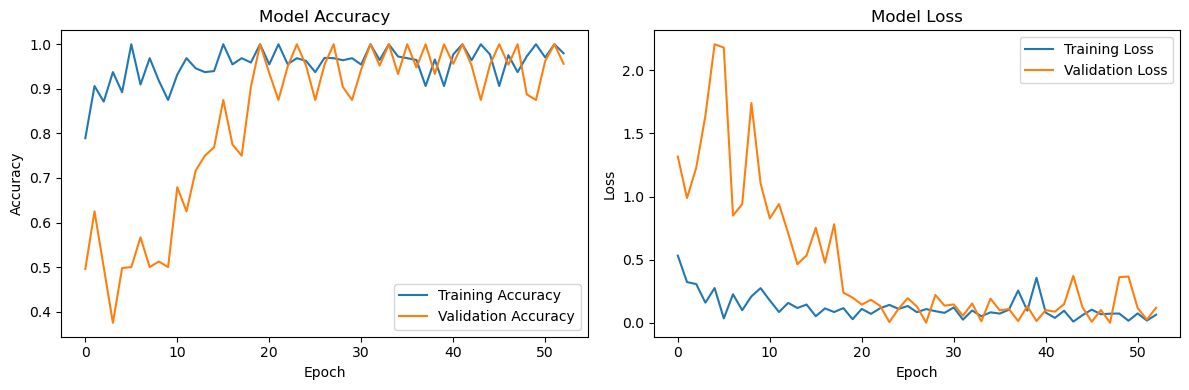

In [70]:
import matplotlib.pyplot as plt

# Mendapatkan nilai terakhir dari validasi akurasi dan loss
final_val_accuracy = history.history.get('val_accuracy', history.history.get('val_categorical_accuracy'))[-1]
final_val_loss = history.history['val_loss'][-1]
print(f"Validation Accuracy (terakhir): {final_val_accuracy * 100:.2f}%")
print(f"Validation Loss (terakhir): {final_val_loss:.4f}")

#save model
#model.export("drowsiness_detection_model")
model.save('namafile_model.h5')
print("Model telah disimpan dalam format TensorFlow SavedModel (.h5)")

# Visualisasi hasil training
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history.get('accuracy', history.history.get('categorical_accuracy')), label='Training Accuracy')
plt.plot(history.history.get('val_accuracy', history.history.get('val_categorical_accuracy')), label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
